### Lab5

In this lab we'll learn how to use PyTorch to build a simple CNN. Pytorch is popular deep learning library used by researchers. It is simple, easy to use due to its tight integration with Python. Its main datastructure is Tensor, which is similar to NumPy's ndarrays and can run on specialized hardwares like GPU, TPU etc.,

The installation instructions for Pytorch are available at https://pytorch.org/get-started/locally/

Colab comes with Pytorch installed by default

In [3]:
import numpy as np
import torch
from torchvision import datasets, transforms
import torchvision

from matplotlib import pyplot as plt
from time import time
from tqdm import tqdm

In [5]:
data = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]

n_data = np.array(data)
t_data = torch.Tensor(data)

print(type(n_data), type(t_data))
print(n_data.shape, t_data.shape)

<class 'numpy.ndarray'> <class 'torch.Tensor'>
(3, 3) torch.Size([3, 3])


In [6]:
# Possible datatypes include int, unsignedint, float, double, half and complex
t_data.dtype

torch.float32

In [7]:
t_data

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [8]:
# Tensors are created on CPUs by default. They can be sent to other devices like 'cuda'
print(t_data.device)
a=t_data.to(torch.device('cuda'))
print(a.device)

cpu


AssertionError: Torch not compiled with CUDA enabled

In [13]:
# Most modules from numpy like np.linalg have pytorch alternatives
# and usually have similar names and behaviour

print(torch.linalg.norm(t_data), torch.sqrt(torch.sum(t_data*t_data)))
print(np.linalg.norm(n_data), np.sqrt(np.sum(n_data*n_data)))

tensor(16.8819) tensor(16.8819)
16.881943016134134 16.881943016134134


**Back-propogation**

Neural networks are trained using backpropagation which requires one to compute gradient of the loss function w.r.t to the weights of the network. Pytorch has a built-in differentiation engine called `torch.autograd`. It builts a computation graph, storing the operations and
the inputs during the computation of a value. The derivative of the `value` computed w.r.t the variables involved can be calculated by calling `value.backward()`

In [14]:
# If requires grad is false, its not included in the derivative computation
W = torch.tensor([[2.0, 0.0], [0.0, 2.0]], requires_grad=True) 
b = torch.ones(2, 1, requires_grad=True)
x = torch.Tensor([[2], [-1]])

$$\begin{align}
    y &= sum(Wx+b)\\
    y &= sum(\begin{bmatrix} 2 & 0 \\ 0 & 2 \end{bmatrix}\begin{bmatrix}2\\-1\end{bmatrix}+\begin{bmatrix}1\\1\end{bmatrix})
\end{align}$$

The above equation is a linear transform followed by a summation operation. `tensor.backward()` only works for scalar valued tensors. For tensors of higher dimensions, the derivatives can be computed by using the autograd engines [`jacobian`](https://pytorch.org/docs/stable/generated/torch.autograd.functional.jacobian.html) function

In [15]:
# A computation graph is computed during this step. More details and a diagram here https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html 
y = torch.sum(W@x+b)

In [16]:
W.grad is None

True

In [17]:
# Compute gradients w.r.t the inputs
y.backward()

In [18]:
W.grad

tensor([[ 2., -1.],
        [ 2., -1.]])

In [19]:
b.grad

tensor([[1.],
        [1.]])

In [20]:
# returns nothing because x.requires_grad is False
x.grad is None

True

In [21]:
# The gradients of the variables are accumulated overtime. They are not overwritten by new backward calls
z = torch.sum(W@x+b)
z.backward()

In [22]:
W.grad

tensor([[ 4., -2.],
        [ 4., -2.]])

Pytorch's backward function only supports calculatin the gradient of a scalar with respect to the variables that are used to compute the scalar.

In [24]:
# k is a 2x1 matrix
k = W@x+b
k.backward()

**Inference**

Sometimes, we need to use the tensors that require gradients for other computations like inference of neural networks and doesn't need their gradients computed. We can disable the gradient tracking and the construction of the gradient graph with `torch.no_grad()`

In [25]:
with torch.no_grad():
    m = torch.sum(W@x+b)
    
m.requires_grad

False

**Practice 1**

In [28]:
# Defining a sinewave and its gradient
x = torch.linspace(0, 2*torch.pi, steps=100, requires_grad=True)
print(x.shape)
sine_x = torch.sin(x)
print(sine_x.shape)

# call backward() function here
torch.sum(sine_x).backward()
#NotImplemented

torch.Size([100])
torch.Size([100])


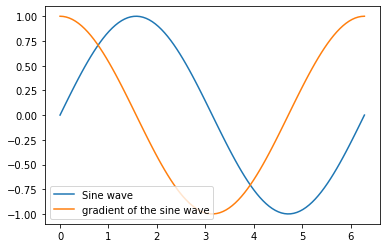

In [29]:
## tensor.detach() is used to get a copy of the tensor and it doesn't require gradient
## tensor.numpy() is used to convert a tensor to a numpy array

plt.plot(x.detach().numpy(), sine_x.detach().numpy(), label='Sine wave')
plt.plot(x.detach().numpy(), x.grad, label='gradient of the sine wave')
plt.legend()
plt.show()

**Using GPU to accelerate computation**

In [2]:
# Check if a gpu is accessible
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
a = torch.Tensor(10000, 10000) # initiates a random tensor of shape 1e4x1e4
a.device

device(type='cpu')

In [4]:
# benchmarking matrix multiplication on CPU
start = time()
a@a # matrix multiplication
end = time()

print(end-start)

31.535592555999756


In [5]:
# tensor.to is used to transfer the tensor to a device of choice
a = a.to(device)
a.device

device(type='cuda', index=0)

In [6]:
# benchmarking matrix multiplication on GPU
start = time()
a@a # matrix multiplication
end = time()

print(end-start)

2.6407177448272705


**Practice 2: Training a neural network in Pytorch**

All models trained in Pytorch are subclassed from `torch.nn.Module`. 

[`torch.nn`](https://pytorch.org/docs/stable/nn.html) is a module that contains all the necessary functions and submodules needed to describe and define a neural network.

 We define a [Lenet5](https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/) network, built to train on [MNIST](http://yann.lecun.com/exdb/mnist/) dataset below. MNIST is popular hand written digit dataset, containing images with digits from 0-9. The architexture of Lenet5 is shown below

 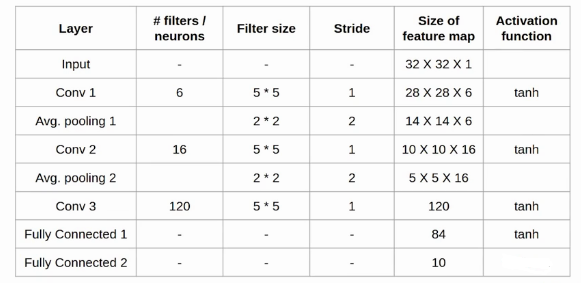

In [ ]:
import torch.nn as nn


class LeNet(torch.nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Sequential(conv, activation, function)
        self.pool1 = nn.AvgPool2d(2)
        self.conv2 = NotImplemented
        self.pool2 = nn.AvgPool2d(2)
        self.conv3 = NotImplemented
        self.fc1 = NotImplemented
        self.fc2 = NotImplemented

    def forward(self, x):
        bs,num_channel,height,width=x.shape
        x = self.conv1(x)
        # continue forward pass
        NotImplemented
        
        # Add a nonlinear function ex) relu

        return x

In [ ]:
# Define the dataset and dataloaders for the training process

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(32),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

batch_size = 64

trainset = datasets.MNIST('./data', train=True, download=True,
                       transform=transform)
testset = datasets.MNIST('./data', train=False,
                   transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,  shuffle=True,  num_workers=16)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,  shuffle=False,  num_workers=16)


classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
plt.imshow(np.transpose(torchvision.utils.make_grid(images).numpy(), (1, 2, 0)))

In [ ]:
model = LeNet()
# Put the model to GPU
NotImplemented

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
epochs = 10

for epoch in tqdm(range(epochs)):
    
    for images, labels in trainloader:
        
        # Autograd accumulates the gradients 
        # zero_grad sets the grads to 0 in the model. 
        optimizer.zero_grad()
        
        # send the images and labels to the target device
        images, labels = images.to(device), labels.to(device)
        
        # run a forward pass through the network
        logits = model(images)
        
        # compute losses
        loss = criterion(logits, labels)
        
        # Run backward pass and compute gradients
        loss.backward()
        
        # Make the weight update
        optimizer.step()

In [ ]:
# Run inference and compute accuracy

predictions = []
targets = []

with torch.no_grad():
     for images, labels in testloader:
        
        # send the images and labels to the target device
        images, labels = images.to(device), labels.to(device)
        
        # run a forward pass through the network
        logits = model(images)
        
        # get the predicted class 
        # preds is of size [batch_size] with integer type
        preds = NotImplemented
        
        predictions.append(preds.cpu().numpy())
        targets.append(labels.cpu().numpy())
        

predictions = np.concatenate(predictions)
targets = np.concatenate(targets)

In [ ]:
accuracy = np.mean(predictions==targets)
accuracy